In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
import torchvision.transforms as TF
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def pair(t):
  return t if isinstance(t,tuple) else (t,t)

  

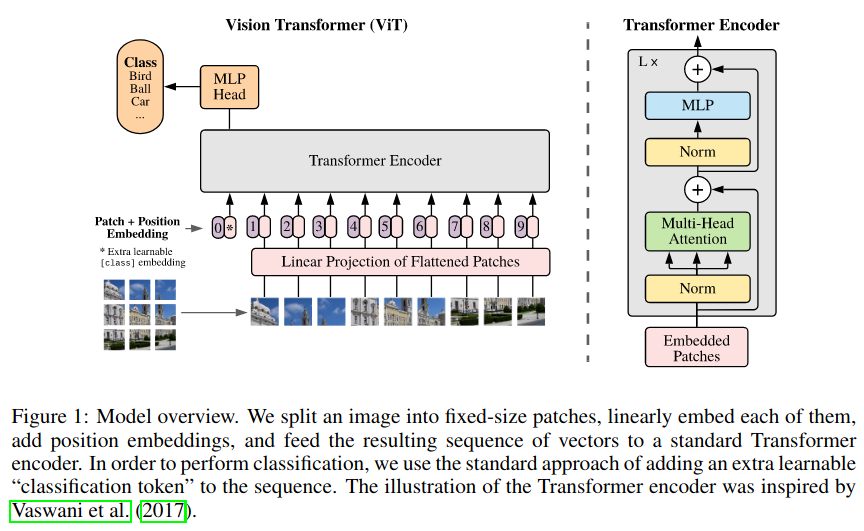

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,dim,hidden_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(dim,hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim,dim)
    )

  def forward(self,x):
    return self.net(x)

In [ ]:
class PreNorm(nn.Module):
  def __init__(self,dim ,fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn= fn
  def forward(self,x,**kwargs):
    return self.fn(self.norm(x),**kwargs)

    

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head)),
                PreNorm(dim, FeedForward(dim, mlp_dim))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [ ]:
class Vit(nn.Module):
  def __init__(self,image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0., pool = 'cls', channels = 3, dim_head = 64):
    super().__init__()

    h , w = pair(image_size)
    p_h , p_w = pair(patch_size)

    assert h % p_h == 0 and w % p_w == 0, 'Image dimensions must be divisible by the patch size.'

    num_p = (h//p_h) * (w//p_w)
    p_dim = channels *p_h * p_w
    assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
    self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p_h, p2 = p_w),
            nn.Linear(p_dim, dim),
        )
    self.pos_embedding = nn.Parameter(torch.randn(1, num_p + 1, dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

    self.pool = pool
    self.to_latent = nn.Identity()


    self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

  def forward(self,x):
    print(x.shape)
    x = self.to_patch_embedding(x)
    print(x.shape)
    b ,n,_ = x.shape
    cls_tokens = repeat(self.cls_token, '1 n d -> b n d', b = b)
    x = torch.cat((cls_tokens, x), dim=1)
    print(x.shape)
    x += self.pos_embedding[:, :(n + 1)]
    print(x.shape)
    x = self.transformer(x)
    print(x.shape)

    x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
    print(x.shape)

    x = self.to_latent(x)
    print(x.shape)
    x = self.mlp_head(x)
    print(x.shape)
    return x 
    



In [ ]:
img = torch.randn(3,1 ,28, 28)

model  =Vit(image_size = 28,
    patch_size = 7,
    num_classes = 10,
    dim = 10,
    depth = 2,
    heads = 8,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1)